# Controlled evaluation on the PlantVillage Dataset

In [1]:
# Importing basic requirements
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import itertools
import evaluate
import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler, random_split
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms, datasets

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve,
    auc,
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.utils import class_weight

# Huggingface transformers library
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    AutoModelForImageClassification,
    ResNetForImageClassification,
    AutoImageProcessor,
    TimmWrapperForImageClassification,
    DefaultDataCollator, # For collating data in the default way
    TrainerCallback,
    EarlyStoppingCallback,
)

from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

### Globals

In [2]:
import torch
# Checking for cuda availability and setting global device variable
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device {DEVICE}.")

Using device cuda.


In [3]:
# Seeding
SEED = 42
torch.manual_seed(SEED)           
random.seed(SEED)                  
np.random.seed(SEED)               
torch.cuda.manual_seed(SEED)       
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False

In [4]:
torch.__version__

'2.5.1'

## Model 

In [5]:
# Model
# Define the pre-trained model string
MODEL_STR = 'microsoft/resnet-50'

## Loading Data 

In [6]:
from pathlib import Path
from tqdm import tqdm
import os

In [7]:
# Absolute data path, change this as required.
data_path = Path("/home/T2410196/KaggleEnv/PlantVillage")

In [8]:
# Import necessary libraries
image_dict = {}

# Define the list of file names
# Initialize empty lists to store file names and labels
file_names = []
labels = []


# Iterate through all image files in the specified directory
for file in tqdm(sorted((data_path.glob('*/*.*[Gg]')))):
    label = str(file).split('/')[-2]  # Extract the label from the file path
    labels.append(label)  # Add the label to the list
    file_names.append(str(file))  # Add the file path to the list

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})

print("Number of images found in dataset:", df.shape[0])

100%|████████████████████████████████| 20638/20638 [00:00<00:00, 1202935.64it/s]

Number of images found in dataset: 20638


In [9]:
df.head(10)

,image,label
0,/home/T2410196/KaggleEnv/PlantVillage/Pepper__...,Pepper__bell___Bacterial_spot
1,/home/T2410196/KaggleEnv/PlantVillage/Pepper__...,Pepper__bell___Bacterial_spot
2,/home/T2410196/KaggleEnv/PlantVillage/Pepper__...,Pepper__bell___Bacterial_spot
3,/home/T2410196/KaggleEnv/PlantVillage/Pepper__...,Pepper__bell___Bacterial_spot
4,/home/T2410196/KaggleEnv/PlantVillage/Pepper__...,Pepper__bell___Bacterial_spot
5,/home/T2410196/KaggleEnv/PlantVillage/Pepper__...,Pepper__bell___Bacterial_spot
6,/home/T2410196/KaggleEnv/PlantVillage/Pepper__...,Pepper__bell___Bacterial_spot
7,/home/T2410196/KaggleEnv/PlantVillage/Pepper__...,Pepper__bell___Bacterial_spot
8,/home/T2410196/KaggleEnv/PlantVillage/Pepper__...,Pepper__bell___Bacterial_spot
9,/home/T2410196/KaggleEnv/PlantVillage/Pepper__...,Pepper__bell___Bacterial_spot


## Data Analysis

In [10]:
print("Unique Labels:\n", df['label'].unique())
print("Number of labels:", len(df['label'].unique()))

Unique Labels:
 ['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']
Number of labels: 15


### Data distribution

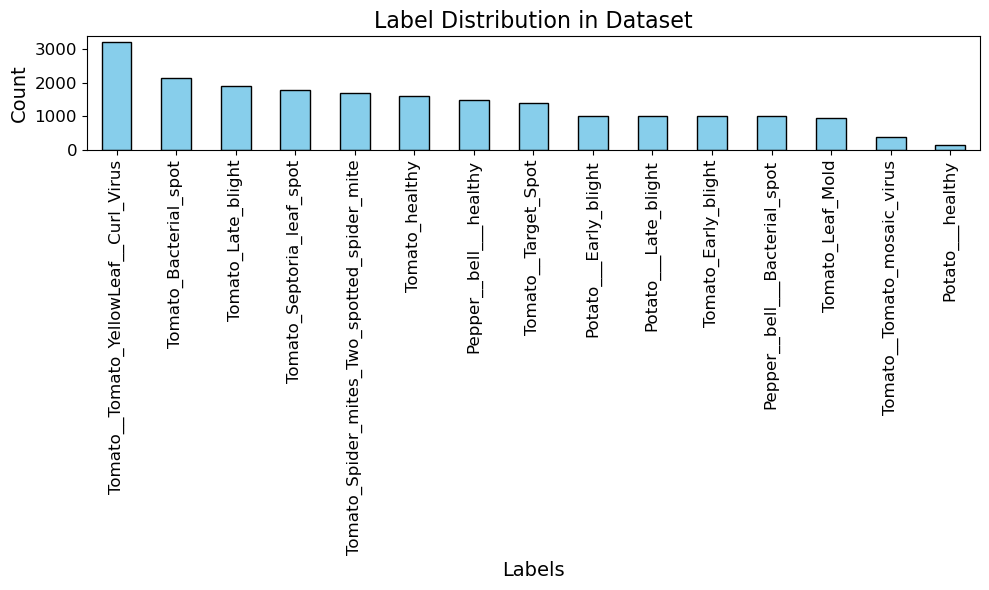

In [11]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add title and labels
plt.title('Label Distribution in Dataset', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

### Image size

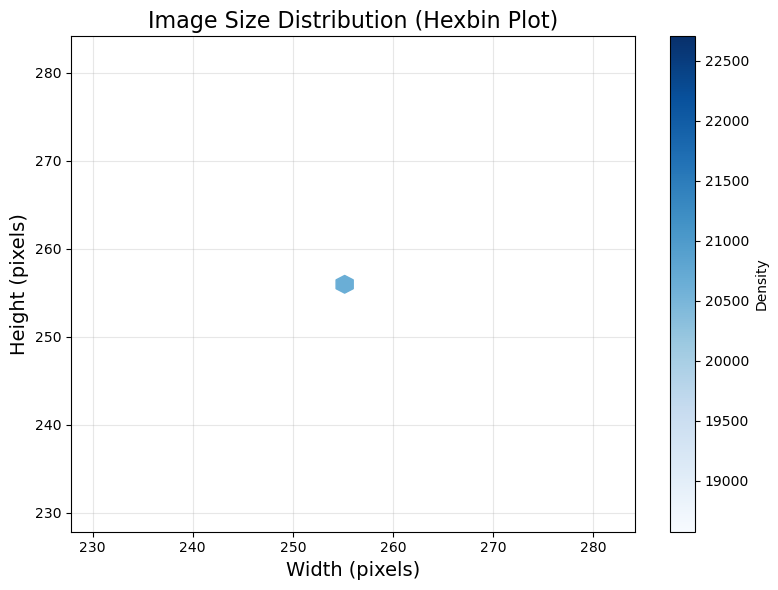

In [12]:
from PIL import Image as PILImage

# List to store image sizes
image_sizes = []

# Iterate through the image paths in the dataframe
for image_path in df['image']:
    try:
        # Open the image and get its size
        with PILImage.open(image_path) as img:
            width, height = img.size
            image_sizes.append((width, height))
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        image_sizes.append((None, None))  # To handle missing or unreadable images

# Separate widths and heights
widths, heights = zip(*image_sizes)

plt.figure(figsize=(8, 6))
plt.hexbin(widths, heights, gridsize=30, cmap='Blues', mincnt=1)

# Add a colorbar to show density levels
plt.colorbar(label='Density')

# Add labels and title
plt.title('Image Size Distribution (Hexbin Plot)', fontsize=16)
plt.xlabel('Width (pixels)', fontsize=14)
plt.ylabel('Height (pixels)', fontsize=14)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

All images have uniform size of (256, 256)

### Random image samples

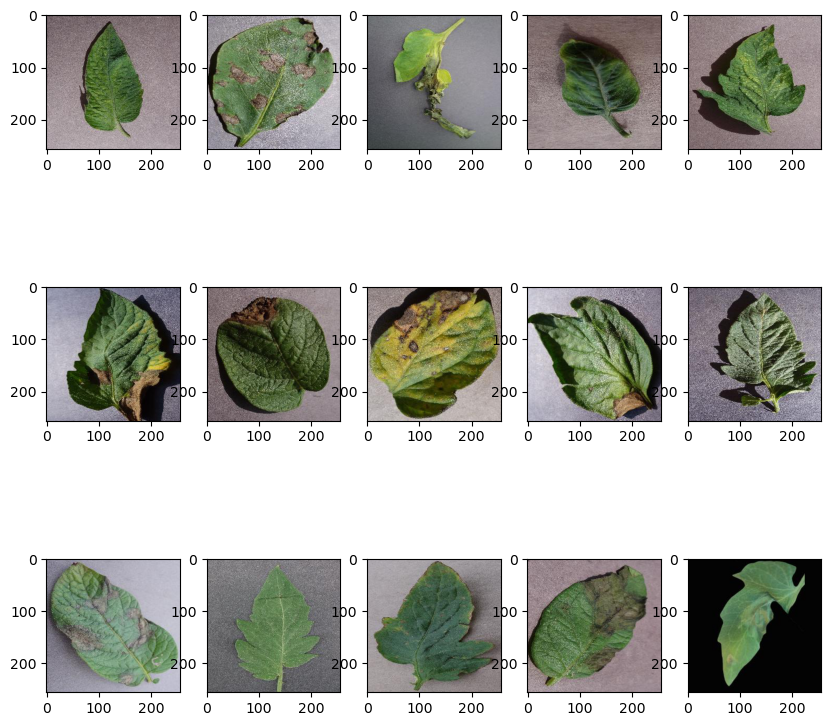

In [13]:
def display_random_images(rows,cols):
    fig, ax = plt.subplots(rows,cols,figsize=(10,10))
    random = df.sample(rows*cols)

    for i in range(rows):
        for j in range(cols):
            image_path=os.path.join(data_path,random.iloc[i*cols+j]['image'])
            ax[i,j].imshow(PILImage.open(image_path))

display_random_images(3,5)

## Splitting the dataframe into train, val and split 

In [14]:
# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Split the data into train and temp (validation + test)
train_df, temp_df = train_test_split(df, test_size=(1 - train_ratio), stratify=df['label'], random_state=42)

# Further split temp into validation and test
val_df, test_df = train_test_split(temp_df, test_size=(test_ratio / (val_ratio + test_ratio)), stratify=temp_df['label'], random_state=42)

# Print the number of samples in each set
print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

Train set: 14446 samples
Validation set: 3096 samples
Test set: 3096 samples


In [15]:
train_df.head()

,image,label
3706,/home/T2410196/KaggleEnv/PlantVillage/Potato__...,Potato___Late_blight
1544,/home/T2410196/KaggleEnv/PlantVillage/Pepper__...,Pepper__bell___healthy
18884,/home/T2410196/KaggleEnv/PlantVillage/Tomato__...,Tomato__Tomato_mosaic_virus
13342,/home/T2410196/KaggleEnv/PlantVillage/Tomato_S...,Tomato_Spider_mites_Two_spotted_spider_mite
3798,/home/T2410196/KaggleEnv/PlantVillage/Potato__...,Potato___Late_blight


In [16]:
val_df.head()

,image,label
3291,/home/T2410196/KaggleEnv/PlantVillage/Potato__...,Potato___Early_blight
12151,/home/T2410196/KaggleEnv/PlantVillage/Tomato_S...,Tomato_Septoria_leaf_spot
9108,/home/T2410196/KaggleEnv/PlantVillage/Tomato_L...,Tomato_Late_blight
12277,/home/T2410196/KaggleEnv/PlantVillage/Tomato_S...,Tomato_Septoria_leaf_spot
8674,/home/T2410196/KaggleEnv/PlantVillage/Tomato_L...,Tomato_Late_blight


In [17]:
test_df.head()

,image,label
15233,/home/T2410196/KaggleEnv/PlantVillage/Tomato__...,Tomato__Target_Spot
2842,/home/T2410196/KaggleEnv/PlantVillage/Potato__...,Potato___Early_blight
19415,/home/T2410196/KaggleEnv/PlantVillage/Tomato_h...,Tomato_healthy
15998,/home/T2410196/KaggleEnv/PlantVillage/Tomato__...,Tomato__Tomato_YellowLeaf__Curl_Virus
14736,/home/T2410196/KaggleEnv/PlantVillage/Tomato__...,Tomato__Target_Spot


## Creating Dataset

In [18]:
# Create a dataset from a Pandas DataFrame.
from datasets import Dataset, Image, ClassLabel

train_data = Dataset.from_pandas(train_df).cast_column("image", Image())
val_data = Dataset.from_pandas(val_df).cast_column("image", Image())
test_data = Dataset.from_pandas(test_df).cast_column("image", Image())

train_data, val_data, test_data

(Dataset({
     features: ['image', 'label', '__index_level_0__'],
     num_rows: 14446
 }),
 Dataset({
     features: ['image', 'label', '__index_level_0__'],
     num_rows: 3096
 }),
 Dataset({
     features: ['image', 'label', '__index_level_0__'],
     num_rows: 3096
 }))

## Data pre-processing

### ClassLabel mapping

In [19]:
# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = sorted(df['label'].unique())

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Pepper__bell___Bacterial_spot', 1: 'Pepper__bell___healthy', 2: 'Potato___Early_blight', 3: 'Potato___Late_blight', 4: 'Potato___healthy', 5: 'Tomato_Bacterial_spot', 6: 'Tomato_Early_blight', 7: 'Tomato_Late_blight', 8: 'Tomato_Leaf_Mold', 9: 'Tomato_Septoria_leaf_spot', 10: 'Tomato_Spider_mites_Two_spotted_spider_mite', 11: 'Tomato__Target_Spot', 12: 'Tomato__Tomato_YellowLeaf__Curl_Virus', 13: 'Tomato__Tomato_mosaic_virus', 14: 'Tomato_healthy'} 

Mapping of Labels to IDs: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


In [20]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

train_data = train_data.map(map_label2id, batched=True)
train_data = train_data.cast_column('label', ClassLabels)

val_data = val_data.map(map_label2id, batched=True)
val_data = val_data.cast_column('label', ClassLabels)

test_data = test_data.map(map_label2id, batched=True)
test_data = test_data.cast_column('label', ClassLabels)

Map:   0%|          | 0/14446 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/14446 [00:00<?, ? examples/s]

Map:   0%|          | 0/3096 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3096 [00:00<?, ? examples/s]

Map:   0%|          | 0/3096 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3096 [00:00<?, ? examples/s]

### Transformations

In [21]:
# Create a processor for ViT model input from the pre-trained model
processor = AutoImageProcessor.from_pretrained(MODEL_STR)
print(processor)
# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["shortest_edge"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
_train_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(30),               # Apply random rotation
        RandomHorizontalFlip(0.5),        # Apply random horizontal flip
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

_test_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)


# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def test_transforms(examples):
    examples['pixel_values'] = [_test_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

Size:  224


In [22]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

# Set the transforms for the validation data
val_data.set_transform(val_transforms)

# SEt the transforms for the test data
test_data.set_transform(test_transforms)

### Collation Function

In [23]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    
    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example['label'] for example in examples])
    
    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

## Loading Model

In [24]:
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ResNetForImageClassification.from_pretrained(
    'output/plantVillage-resnet-50/Jan11-17:03:39/checkpoint-22600', 
    num_labels=len(labels_list), ignore_mismatched_sizes=True)

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

23.538767


## Defining model evaluation metrics

In [25]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

# Load the accuracy metric
accuracy = evaluate.load("accuracy")

# Define a function to compute metrics
def compute_metrics(eval_pred):

    # Extract predictions and true labels
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids

    # Convert label_ids to one-hot encoding
    num_classes = predictions.shape[1]
    label_one_hot = np.eye(num_classes)[label_ids]

    # Top-1 Accuracy
    top1_predicted_labels = predictions.argmax(axis=1)
    top1_accuracy = accuracy.compute(predictions=top1_predicted_labels, references=label_ids)['accuracy']
    
    # Top-5 Accuracy
    top5_predicted_labels = np.argsort(predictions, axis=1)[:, -5:]  # Get indices of top-5 predictions
    top5_accuracy = np.mean(
        [label_ids[i] in top5_predicted_labels[i] for i in range(len(label_ids))]
    )

    # Precision, Recall, F1 Score
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true=label_ids,
        y_pred=top1_predicted_labels,
        average='weighted'  # Weighted average considers class imbalance
    )
    
    # AUC-ROC Score (macro-averaged across all classes)
    try:
        probs = torch.softmax(torch.tensor(predictions), axis=1)
        auc_roc = roc_auc_score(y_true=label_ids, y_score=probs, average='macro', multi_class='ovr')
    except ValueError:
        # Handle case where AUC-ROC cannot be computed (e.g., single-class batch)
        auc_roc = None

    # Return all metrics
    return {
        "accuracy": top1_accuracy,         # Top-1 accuracy
        "top5_accuracy": top5_accuracy,   # Top-5 accuracy
        "precision": precision,           # Weighted precision
        "recall": recall,                 # Weighted recall
        "f1_score": f1,                   # Weighted F1 score
        "auc_roc": auc_roc                # Macro-averaged AUC-ROC score
    }


## Custom trainer callbacks for logging

In [26]:
import torch
# from fvcore.nn import FlopCountAnalysis
from transformers import TrainerCallback
from torch.utils.tensorboard import SummaryWriter


class CustomTensorBoardCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.writer = None

    def on_train_begin(self, args, state, control, **kwargs):
        # Initialize TensorBoard writer
        self.writer = SummaryWriter(log_dir=args.logging_dir)
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        # Ensures this executes only during training
        if state.epoch is None or logs is None:
            return
            
        metrics = logs

        # Separate evaluation and other metrics (training loss has no prefix)
        evaluation_metrics = {key: value for key, value in metrics.items() if key.startswith('eval_')}
        other_metrics = {key: value for key, value in metrics.items() if key == 'learning_rate'}
        training_metrics = {key: value for key, value in metrics.items() if key not in evaluation_metrics and key not in other_metrics}

        # Log training metrics
        for key, value in training_metrics.items():
            self.writer.add_scalar(f"Training/{key}", value, state.epoch)

        # Log evaluation metrics
        for key, value in evaluation_metrics.items():
            self.writer.add_scalar(f"Evaluation/{key.replace('eval_', '')}", value, state.epoch)

        # Log learning rate
        for key, value in other_metrics.items():
            self.writer.add_scalar(f"LearningRate/{key}", value, state.epoch)

    def on_train_end(self, args, state, control, **kwargs):
        # Close TensorBoard writer
        if self.writer:
            self.writer.close()
            
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

## Defining custom trainer

In [27]:
# Define the name of the evaluation metric to be used during training and evaluation.
metric_name = "accuracy"

# Define the name of the model, which will be used to create a directory for saving model checkpoints and outputs.
model_name = f'plantVillage-{MODEL_STR.split("/")[1]}/{datetime.datetime.now().strftime("%b%d-%H:%M:%S")}'

# Define the number of training epochs for the model.
num_train_epochs = 50

# Create an instance of TrainingArguments to configure training settings.
training_args = TrainingArguments(
    # Specify the directory where model checkpoints and outputs will be saved.
    output_dir=f'./output/{model_name}',
    
    # Specify the directory where training logs will be stored.
    logging_dir=f'./logs/{model_name}',

    logging_strategy='epoch',
    
    # Define the evaluation strategy, which is performed at the end of each epoch.
    eval_strategy="epoch",
    
    # Set the learning rate for the optimizer.
    learning_rate=3e-6,
    
    # Default optimizer, scheduler (AdamW, Linear)
    
    # Define the batch size for training on each device.
    per_device_train_batch_size=32,
    
    # Define the batch size for evaluation on each device.
    per_device_eval_batch_size=16,
    
    # Specify the total number of training epochs.
    num_train_epochs=num_train_epochs,
    
    # Apply weight decay to prevent overfitting.
    weight_decay=0.02,
    
    # Set the number of warm-up steps for the learning rate scheduler.
    warmup_steps=5,  # A fraction of the total training steps is often used (e.g., 10%).
    
    # Disable the removal of unused columns from the dataset.
    remove_unused_columns=False,
    
    # Define the strategy for saving model checkpoints (per epoch in this case).
    save_strategy='epoch',
    
    # Load the best model at the end of training.
    load_best_model_at_end=True,
    
    # Limit the total number of saved checkpoints to save space.
    save_total_limit=1,
    
    # Specify that training progress should be reported to tensorboard.
    report_to="tensorboard"
)


In [28]:
# Define custom callbacks
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)
tensorboard_callback = CustomTensorBoardCallback()


# Initialize Trainer with all callbacks
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback, tensorboard_callback]
)

In [29]:
DEVICE = trainer.model.device

DEVICE

device(type='cuda', index=0)

## Train

### Pre-training evaluation on the val set

In [90]:
trainer.evaluate()

  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 2.7036707401275635,
 'eval_model_preparation_time': 0.0013,
 'eval_accuracy': 0.0710594315245478,
 'eval_top5_accuracy': 0.3727390180878553,
 'eval_precision': 0.13310679914246168,
 'eval_recall': 0.0710594315245478,
 'eval_f1_score': 0.03567798461554105,
 'eval_runtime': 4.897,
 'eval_samples_per_second': 632.225,
 'eval_steps_per_second': 39.616}

### Training

In [91]:
trainer.train()

  0%|          | 0/22600 [00:00<?, ?it/s]

{'loss': 2.6832, 'grad_norm': 2.657518148422241, 'learning_rate': 2.9406505864129232e-06, 'epoch': 1.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 2.6604909896850586, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.14114987080103358, 'eval_top5_accuracy': 0.5303617571059431, 'eval_precision': 0.16612111127562443, 'eval_recall': 0.14114987080103358, 'eval_f1_score': 0.09196786590644113, 'eval_runtime': 4.6733, 'eval_samples_per_second': 662.486, 'eval_steps_per_second': 41.512, 'epoch': 1.0}
{'loss': 2.6343, 'grad_norm': 3.196695327758789, 'learning_rate': 2.8806373091391905e-06, 'epoch': 2.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 2.615267276763916, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.1776485788113695, 'eval_top5_accuracy': 0.601421188630491, 'eval_precision': 0.1901029034560551, 'eval_recall': 0.1776485788113695, 'eval_f1_score': 0.08216681238888082, 'eval_runtime': 4.8046, 'eval_samples_per_second': 644.377, 'eval_steps_per_second': 40.378, 'epoch': 2.0}
{'loss': 2.5887, 'grad_norm': 2.9056591987609863, 'learning_rate': 2.820624031865457e-06, 'epoch': 3.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 2.5682430267333984, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.16472868217054262, 'eval_top5_accuracy': 0.6314599483204134, 'eval_precision': 0.17276343262193855, 'eval_recall': 0.16472868217054262, 'eval_f1_score': 0.05936386249347284, 'eval_runtime': 4.8238, 'eval_samples_per_second': 641.814, 'eval_steps_per_second': 40.217, 'epoch': 3.0}
{'loss': 2.5392, 'grad_norm': 2.5639078617095947, 'learning_rate': 2.760610754591724e-06, 'epoch': 4.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 2.510016441345215, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.15891472868217055, 'eval_top5_accuracy': 0.6353359173126615, 'eval_precision': 0.20477373778666022, 'eval_recall': 0.15891472868217055, 'eval_f1_score': 0.0489709261357774, 'eval_runtime': 4.6424, 'eval_samples_per_second': 666.899, 'eval_steps_per_second': 41.789, 'epoch': 4.0}
{'loss': 2.491, 'grad_norm': 3.179569959640503, 'learning_rate': 2.7005974773179907e-06, 'epoch': 5.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 2.4544460773468018, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.15762273901808785, 'eval_top5_accuracy': 0.6463178294573644, 'eval_precision': 0.14814086333238624, 'eval_recall': 0.15762273901808785, 'eval_f1_score': 0.04637628232145489, 'eval_runtime': 4.9971, 'eval_samples_per_second': 619.554, 'eval_steps_per_second': 38.822, 'epoch': 5.0}
{'loss': 2.4352, 'grad_norm': 2.839794635772705, 'learning_rate': 2.6405842000442575e-06, 'epoch': 6.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 2.3933024406433105, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.15794573643410853, 'eval_top5_accuracy': 0.6572997416020672, 'eval_precision': 0.3041241802447151, 'eval_recall': 0.15794573643410853, 'eval_f1_score': 0.047058089225539654, 'eval_runtime': 4.8319, 'eval_samples_per_second': 640.744, 'eval_steps_per_second': 40.15, 'epoch': 6.0}
{'loss': 2.3794, 'grad_norm': 4.236118793487549, 'learning_rate': 2.5805709227705244e-06, 'epoch': 7.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 2.328268527984619, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.15859173126614987, 'eval_top5_accuracy': 0.6618217054263565, 'eval_precision': 0.3306251748864652, 'eval_recall': 0.15859173126614987, 'eval_f1_score': 0.048274561546338926, 'eval_runtime': 5.0546, 'eval_samples_per_second': 612.515, 'eval_steps_per_second': 38.381, 'epoch': 7.0}
{'loss': 2.3246, 'grad_norm': 4.051197528839111, 'learning_rate': 2.5205576454967912e-06, 'epoch': 8.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 2.2743453979492188, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.1640826873385013, 'eval_top5_accuracy': 0.6750645994832042, 'eval_precision': 0.36641090760162803, 'eval_recall': 0.1640826873385013, 'eval_f1_score': 0.05895415009403926, 'eval_runtime': 4.841, 'eval_samples_per_second': 639.533, 'eval_steps_per_second': 40.074, 'epoch': 8.0}
{'loss': 2.269, 'grad_norm': 3.0584723949432373, 'learning_rate': 2.4605443682230585e-06, 'epoch': 9.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 2.22525954246521, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.17215762273901808, 'eval_top5_accuracy': 0.687984496124031, 'eval_precision': 0.33516282908925515, 'eval_recall': 0.17215762273901808, 'eval_f1_score': 0.0740123526382094, 'eval_runtime': 4.7166, 'eval_samples_per_second': 656.411, 'eval_steps_per_second': 41.132, 'epoch': 9.0}
{'loss': 2.2191, 'grad_norm': 4.1219096183776855, 'learning_rate': 2.4005310909493254e-06, 'epoch': 10.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 2.1738245487213135, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.19767441860465115, 'eval_top5_accuracy': 0.7031653746770026, 'eval_precision': 0.3478448504690037, 'eval_recall': 0.19767441860465115, 'eval_f1_score': 0.11797231860507133, 'eval_runtime': 4.8797, 'eval_samples_per_second': 634.459, 'eval_steps_per_second': 39.756, 'epoch': 10.0}
{'loss': 2.1668, 'grad_norm': 2.9478938579559326, 'learning_rate': 2.3405178136755922e-06, 'epoch': 11.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 2.1177501678466797, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.2374031007751938, 'eval_top5_accuracy': 0.7235142118863049, 'eval_precision': 0.37462498312704284, 'eval_recall': 0.2374031007751938, 'eval_f1_score': 0.1742070384112018, 'eval_runtime': 4.8857, 'eval_samples_per_second': 633.689, 'eval_steps_per_second': 39.708, 'epoch': 11.0}
{'loss': 2.111, 'grad_norm': 4.114749431610107, 'learning_rate': 2.2805045364018586e-06, 'epoch': 12.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 2.067288875579834, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.3184754521963824, 'eval_top5_accuracy': 0.7571059431524548, 'eval_precision': 0.453587447502473, 'eval_recall': 0.3184754521963824, 'eval_f1_score': 0.2622445543217832, 'eval_runtime': 4.7557, 'eval_samples_per_second': 651.013, 'eval_steps_per_second': 40.793, 'epoch': 12.0}
{'loss': 2.0562, 'grad_norm': 4.610367298126221, 'learning_rate': 2.2204912591281255e-06, 'epoch': 13.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 2.016606569290161, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.393733850129199, 'eval_top5_accuracy': 0.7877906976744186, 'eval_precision': 0.46248472974604904, 'eval_recall': 0.393733850129199, 'eval_f1_score': 0.3299271832731954, 'eval_runtime': 5.2453, 'eval_samples_per_second': 590.245, 'eval_steps_per_second': 36.986, 'epoch': 13.0}
{'loss': 2.0014, 'grad_norm': 4.793969631195068, 'learning_rate': 2.1604779818543924e-06, 'epoch': 14.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.9457679986953735, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.3724160206718346, 'eval_top5_accuracy': 0.7978036175710594, 'eval_precision': 0.45487986139247033, 'eval_recall': 0.3724160206718346, 'eval_f1_score': 0.30591084936240764, 'eval_runtime': 5.5286, 'eval_samples_per_second': 559.993, 'eval_steps_per_second': 35.09, 'epoch': 14.0}
{'loss': 1.9417, 'grad_norm': 3.9889519214630127, 'learning_rate': 2.1004647045806596e-06, 'epoch': 15.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.8962684869766235, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.4731912144702842, 'eval_top5_accuracy': 0.8394702842377261, 'eval_precision': 0.5122501142407838, 'eval_recall': 0.4731912144702842, 'eval_f1_score': 0.395083992396085, 'eval_runtime': 5.6556, 'eval_samples_per_second': 547.421, 'eval_steps_per_second': 34.302, 'epoch': 15.0}
{'loss': 1.8783, 'grad_norm': 3.2381036281585693, 'learning_rate': 2.0404514273069265e-06, 'epoch': 16.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.835905909538269, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.5032299741602068, 'eval_top5_accuracy': 0.8540051679586563, 'eval_precision': 0.5196651883671966, 'eval_recall': 0.5032299741602068, 'eval_f1_score': 0.41837992171257693, 'eval_runtime': 5.5333, 'eval_samples_per_second': 559.525, 'eval_steps_per_second': 35.061, 'epoch': 16.0}
{'loss': 1.8178, 'grad_norm': 3.377314329147339, 'learning_rate': 1.9804381500331933e-06, 'epoch': 17.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.7753100395202637, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.5352067183462532, 'eval_top5_accuracy': 0.8798449612403101, 'eval_precision': 0.5667629974304784, 'eval_recall': 0.5352067183462532, 'eval_f1_score': 0.45338105240340154, 'eval_runtime': 5.4349, 'eval_samples_per_second': 569.647, 'eval_steps_per_second': 35.695, 'epoch': 17.0}
{'loss': 1.7529, 'grad_norm': 3.6019787788391113, 'learning_rate': 1.92042487275946e-06, 'epoch': 18.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.7008785009384155, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.5494186046511628, 'eval_top5_accuracy': 0.8888888888888888, 'eval_precision': 0.5781598161062951, 'eval_recall': 0.5494186046511628, 'eval_f1_score': 0.46714631437945575, 'eval_runtime': 5.5481, 'eval_samples_per_second': 558.025, 'eval_steps_per_second': 34.967, 'epoch': 18.0}
{'loss': 1.6889, 'grad_norm': 3.6444509029388428, 'learning_rate': 1.8604115954857268e-06, 'epoch': 19.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.6408354043960571, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.5813953488372093, 'eval_top5_accuracy': 0.9034237726098191, 'eval_precision': 0.6037986037385791, 'eval_recall': 0.5813953488372093, 'eval_f1_score': 0.5009795878788649, 'eval_runtime': 5.4435, 'eval_samples_per_second': 568.747, 'eval_steps_per_second': 35.639, 'epoch': 19.0}
{'loss': 1.6299, 'grad_norm': 4.0485148429870605, 'learning_rate': 1.8003983182119937e-06, 'epoch': 20.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.5741639137268066, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.5849483204134367, 'eval_top5_accuracy': 0.916343669250646, 'eval_precision': 0.6601771432450897, 'eval_recall': 0.5849483204134367, 'eval_f1_score': 0.5069610377475796, 'eval_runtime': 5.4851, 'eval_samples_per_second': 564.433, 'eval_steps_per_second': 35.368, 'epoch': 20.0}
{'loss': 1.5676, 'grad_norm': 5.125537872314453, 'learning_rate': 1.7403850409382606e-06, 'epoch': 21.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.5247001647949219, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.6091731266149871, 'eval_top5_accuracy': 0.9253875968992248, 'eval_precision': 0.667863896435054, 'eval_recall': 0.6091731266149871, 'eval_f1_score': 0.5371748529929411, 'eval_runtime': 5.5507, 'eval_samples_per_second': 557.763, 'eval_steps_per_second': 34.95, 'epoch': 21.0}
{'loss': 1.5067, 'grad_norm': 3.5948357582092285, 'learning_rate': 1.6803717636645276e-06, 'epoch': 22.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.462363600730896, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.6224160206718347, 'eval_top5_accuracy': 0.9341085271317829, 'eval_precision': 0.677787160102246, 'eval_recall': 0.6224160206718347, 'eval_f1_score': 0.555571097386584, 'eval_runtime': 5.6971, 'eval_samples_per_second': 543.434, 'eval_steps_per_second': 34.052, 'epoch': 22.0}
{'loss': 1.4618, 'grad_norm': 4.015926837921143, 'learning_rate': 1.6203584863907945e-06, 'epoch': 23.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.3908170461654663, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.6356589147286822, 'eval_top5_accuracy': 0.937984496124031, 'eval_precision': 0.6770094892492693, 'eval_recall': 0.6356589147286822, 'eval_f1_score': 0.5730795991153551, 'eval_runtime': 7.3009, 'eval_samples_per_second': 424.06, 'eval_steps_per_second': 26.572, 'epoch': 23.0}
{'loss': 1.4067, 'grad_norm': 3.825636863708496, 'learning_rate': 1.5603452091170613e-06, 'epoch': 24.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.353495478630066, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.6572997416020672, 'eval_top5_accuracy': 0.9444444444444444, 'eval_precision': 0.6999600789045088, 'eval_recall': 0.6572997416020672, 'eval_f1_score': 0.6012742202285164, 'eval_runtime': 7.1219, 'eval_samples_per_second': 434.714, 'eval_steps_per_second': 27.24, 'epoch': 24.0}
{'loss': 1.3536, 'grad_norm': 3.4107182025909424, 'learning_rate': 1.5003319318433282e-06, 'epoch': 25.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.3020991086959839, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.6715116279069767, 'eval_top5_accuracy': 0.9467054263565892, 'eval_precision': 0.704038957025471, 'eval_recall': 0.6715116279069767, 'eval_f1_score': 0.620772634001156, 'eval_runtime': 7.0377, 'eval_samples_per_second': 439.914, 'eval_steps_per_second': 27.566, 'epoch': 25.0}
{'loss': 1.3052, 'grad_norm': 4.362298011779785, 'learning_rate': 1.4403186545695953e-06, 'epoch': 26.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.2459689378738403, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.6782945736434108, 'eval_top5_accuracy': 0.9515503875968992, 'eval_precision': 0.6985258914504434, 'eval_recall': 0.6782945736434108, 'eval_f1_score': 0.6306782540294679, 'eval_runtime': 7.1799, 'eval_samples_per_second': 431.206, 'eval_steps_per_second': 27.02, 'epoch': 26.0}
{'loss': 1.257, 'grad_norm': 3.5942769050598145, 'learning_rate': 1.380305377295862e-06, 'epoch': 27.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.2051273584365845, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.7118863049095607, 'eval_top5_accuracy': 0.9528423772609819, 'eval_precision': 0.7150629393394512, 'eval_recall': 0.7118863049095607, 'eval_f1_score': 0.6646241375968556, 'eval_runtime': 7.0674, 'eval_samples_per_second': 438.07, 'eval_steps_per_second': 27.45, 'epoch': 27.0}
{'loss': 1.2121, 'grad_norm': 3.580958604812622, 'learning_rate': 1.3202921000221288e-06, 'epoch': 28.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.161721110343933, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.7160852713178295, 'eval_top5_accuracy': 0.9534883720930233, 'eval_precision': 0.7212044623072944, 'eval_recall': 0.7160852713178295, 'eval_f1_score': 0.6759446145001631, 'eval_runtime': 7.1676, 'eval_samples_per_second': 431.944, 'eval_steps_per_second': 27.066, 'epoch': 28.0}
{'loss': 1.1732, 'grad_norm': 4.487319469451904, 'learning_rate': 1.2602788227483956e-06, 'epoch': 29.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.1110515594482422, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.7370801033591732, 'eval_top5_accuracy': 0.959625322997416, 'eval_precision': 0.7293640091962708, 'eval_recall': 0.7370801033591732, 'eval_f1_score': 0.6981512551635961, 'eval_runtime': 7.1865, 'eval_samples_per_second': 430.808, 'eval_steps_per_second': 26.995, 'epoch': 29.0}
{'loss': 1.1303, 'grad_norm': 3.0805652141571045, 'learning_rate': 1.2002655454746627e-06, 'epoch': 30.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0785057544708252, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.7506459948320413, 'eval_top5_accuracy': 0.960594315245478, 'eval_precision': 0.7386229136704164, 'eval_recall': 0.7506459948320413, 'eval_f1_score': 0.7115530962369612, 'eval_runtime': 6.8998, 'eval_samples_per_second': 448.707, 'eval_steps_per_second': 28.117, 'epoch': 30.0}
{'loss': 1.0939, 'grad_norm': 3.054110288619995, 'learning_rate': 1.1402522682009293e-06, 'epoch': 31.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0377509593963623, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.7396640826873385, 'eval_top5_accuracy': 0.9628552971576227, 'eval_precision': 0.7275690585850031, 'eval_recall': 0.7396640826873385, 'eval_f1_score': 0.70322145510542, 'eval_runtime': 7.1074, 'eval_samples_per_second': 435.6, 'eval_steps_per_second': 27.295, 'epoch': 31.0}
{'loss': 1.0601, 'grad_norm': 2.7084970474243164, 'learning_rate': 1.0802389909271962e-06, 'epoch': 32.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0065829753875732, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.7574289405684754, 'eval_top5_accuracy': 0.9647932816537468, 'eval_precision': 0.7813680528490716, 'eval_recall': 0.7574289405684754, 'eval_f1_score': 0.7212317256990386, 'eval_runtime': 7.105, 'eval_samples_per_second': 435.748, 'eval_steps_per_second': 27.305, 'epoch': 32.0}
{'loss': 1.03, 'grad_norm': 3.602815628051758, 'learning_rate': 1.0202257136534632e-06, 'epoch': 33.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9597623944282532, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.7771317829457365, 'eval_top5_accuracy': 0.9660852713178295, 'eval_precision': 0.7928210385928457, 'eval_recall': 0.7771317829457365, 'eval_f1_score': 0.7417828402887613, 'eval_runtime': 7.1597, 'eval_samples_per_second': 432.421, 'eval_steps_per_second': 27.096, 'epoch': 33.0}
{'loss': 1.0046, 'grad_norm': 3.7087466716766357, 'learning_rate': 9.6021243637973e-07, 'epoch': 34.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9615618586540222, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.773578811369509, 'eval_top5_accuracy': 0.9686692506459949, 'eval_precision': 0.7923942438656955, 'eval_recall': 0.773578811369509, 'eval_f1_score': 0.7402962992192276, 'eval_runtime': 6.7999, 'eval_samples_per_second': 455.298, 'eval_steps_per_second': 28.53, 'epoch': 34.0}
{'loss': 0.9788, 'grad_norm': 2.7198145389556885, 'learning_rate': 9.001991591059969e-07, 'epoch': 35.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9227301478385925, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.7822997416020672, 'eval_top5_accuracy': 0.9702842377260982, 'eval_precision': 0.7942046849536831, 'eval_recall': 0.7822997416020672, 'eval_f1_score': 0.7500348806211409, 'eval_runtime': 6.3908, 'eval_samples_per_second': 484.445, 'eval_steps_per_second': 30.356, 'epoch': 35.0}
{'loss': 0.9504, 'grad_norm': 3.585028886795044, 'learning_rate': 8.401858818322638e-07, 'epoch': 36.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.8976626396179199, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.7890826873385013, 'eval_top5_accuracy': 0.9725452196382429, 'eval_precision': 0.8006172111591955, 'eval_recall': 0.7890826873385013, 'eval_f1_score': 0.7592058557556214, 'eval_runtime': 6.3689, 'eval_samples_per_second': 486.111, 'eval_steps_per_second': 30.46, 'epoch': 36.0}
{'loss': 0.9309, 'grad_norm': 4.2177605628967285, 'learning_rate': 7.801726045585307e-07, 'epoch': 37.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.8871056437492371, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.7968346253229974, 'eval_top5_accuracy': 0.9706072351421189, 'eval_precision': 0.8063709289862685, 'eval_recall': 0.7968346253229974, 'eval_f1_score': 0.7667677561645981, 'eval_runtime': 6.36, 'eval_samples_per_second': 486.795, 'eval_steps_per_second': 30.503, 'epoch': 37.0}
{'loss': 0.9166, 'grad_norm': 3.9333479404449463, 'learning_rate': 7.201593272847976e-07, 'epoch': 38.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.8483909368515015, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.8104005167958657, 'eval_top5_accuracy': 0.9748062015503876, 'eval_precision': 0.8099738763705031, 'eval_recall': 0.8104005167958657, 'eval_f1_score': 0.7809300376335789, 'eval_runtime': 6.3396, 'eval_samples_per_second': 488.356, 'eval_steps_per_second': 30.601, 'epoch': 38.0}
{'loss': 0.8974, 'grad_norm': 3.92171573638916, 'learning_rate': 6.601460500110644e-07, 'epoch': 39.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.8345000743865967, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.8142764857881137, 'eval_top5_accuracy': 0.9751291989664083, 'eval_precision': 0.8139640170607785, 'eval_recall': 0.8142764857881137, 'eval_f1_score': 0.7847839626860059, 'eval_runtime': 6.4239, 'eval_samples_per_second': 481.952, 'eval_steps_per_second': 30.2, 'epoch': 39.0}
{'loss': 0.873, 'grad_norm': 3.831271171569824, 'learning_rate': 6.001327727373313e-07, 'epoch': 40.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.8219523429870605, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.8133074935400517, 'eval_top5_accuracy': 0.9728682170542635, 'eval_precision': 0.8159639038967738, 'eval_recall': 0.8133074935400517, 'eval_f1_score': 0.7860150175765981, 'eval_runtime': 6.343, 'eval_samples_per_second': 488.099, 'eval_steps_per_second': 30.585, 'epoch': 40.0}
{'loss': 0.8666, 'grad_norm': 3.9285802841186523, 'learning_rate': 5.401194954635981e-07, 'epoch': 41.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.8015004396438599, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.8204134366925064, 'eval_top5_accuracy': 0.977390180878553, 'eval_precision': 0.8180791141118672, 'eval_recall': 0.8204134366925064, 'eval_f1_score': 0.7926628104568355, 'eval_runtime': 6.3712, 'eval_samples_per_second': 485.939, 'eval_steps_per_second': 30.45, 'epoch': 41.0}
{'loss': 0.8499, 'grad_norm': 3.322664260864258, 'learning_rate': 4.80106218189865e-07, 'epoch': 42.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.7947001457214355, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.8223514211886305, 'eval_top5_accuracy': 0.9780361757105943, 'eval_precision': 0.8168666316858902, 'eval_recall': 0.8223514211886305, 'eval_f1_score': 0.7953386567670229, 'eval_runtime': 6.4094, 'eval_samples_per_second': 483.04, 'eval_steps_per_second': 30.268, 'epoch': 42.0}
{'loss': 0.8399, 'grad_norm': 5.97817325592041, 'learning_rate': 4.200929409161319e-07, 'epoch': 43.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.8077106475830078, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.8152454780361758, 'eval_top5_accuracy': 0.9767441860465116, 'eval_precision': 0.8136242497480194, 'eval_recall': 0.8152454780361758, 'eval_f1_score': 0.7873380488954682, 'eval_runtime': 6.3212, 'eval_samples_per_second': 489.78, 'eval_steps_per_second': 30.69, 'epoch': 43.0}
{'loss': 0.8338, 'grad_norm': 3.8919107913970947, 'learning_rate': 3.600796636423988e-07, 'epoch': 44.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.7728456258773804, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.8249354005167958, 'eval_top5_accuracy': 0.979328165374677, 'eval_precision': 0.8187586064705694, 'eval_recall': 0.8249354005167958, 'eval_f1_score': 0.7970896342541227, 'eval_runtime': 6.3539, 'eval_samples_per_second': 487.261, 'eval_steps_per_second': 30.532, 'epoch': 44.0}
{'loss': 0.8221, 'grad_norm': 3.2313923835754395, 'learning_rate': 3.0006638636866567e-07, 'epoch': 45.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.7712902426719666, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.8217054263565892, 'eval_top5_accuracy': 0.9770671834625323, 'eval_precision': 0.8202142281470765, 'eval_recall': 0.8217054263565892, 'eval_f1_score': 0.7951884857370304, 'eval_runtime': 6.3875, 'eval_samples_per_second': 484.694, 'eval_steps_per_second': 30.372, 'epoch': 45.0}
{'loss': 0.8171, 'grad_norm': 2.655831813812256, 'learning_rate': 2.400531090949325e-07, 'epoch': 46.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.7620490193367004, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.8178294573643411, 'eval_top5_accuracy': 0.9809431524547804, 'eval_precision': 0.8133245701765013, 'eval_recall': 0.8178294573643411, 'eval_f1_score': 0.791040889304831, 'eval_runtime': 6.3663, 'eval_samples_per_second': 486.312, 'eval_steps_per_second': 30.473, 'epoch': 46.0}
{'loss': 0.8175, 'grad_norm': 3.1495656967163086, 'learning_rate': 1.800398318211994e-07, 'epoch': 47.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.7538501620292664, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.8288113695090439, 'eval_top5_accuracy': 0.9790051679586563, 'eval_precision': 0.8225067337968408, 'eval_recall': 0.8288113695090439, 'eval_f1_score': 0.800725094461356, 'eval_runtime': 6.3596, 'eval_samples_per_second': 486.822, 'eval_steps_per_second': 30.505, 'epoch': 47.0}
{'loss': 0.8112, 'grad_norm': 3.14359450340271, 'learning_rate': 1.2002655454746626e-07, 'epoch': 48.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.75732421875, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.8259043927648578, 'eval_top5_accuracy': 0.9799741602067183, 'eval_precision': 0.8201478953941659, 'eval_recall': 0.8259043927648578, 'eval_f1_score': 0.7985204518874797, 'eval_runtime': 6.3162, 'eval_samples_per_second': 490.17, 'eval_steps_per_second': 30.715, 'epoch': 48.0}
{'loss': 0.7997, 'grad_norm': 2.29221773147583, 'learning_rate': 6.001327727373313e-08, 'epoch': 49.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.7681416273117065, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.8239664082687338, 'eval_top5_accuracy': 0.9802971576227391, 'eval_precision': 0.8188829609267796, 'eval_recall': 0.8239664082687338, 'eval_f1_score': 0.7983827180227221, 'eval_runtime': 6.3661, 'eval_samples_per_second': 486.329, 'eval_steps_per_second': 30.474, 'epoch': 49.0}
{'loss': 0.8057, 'grad_norm': 2.720665216445923, 'learning_rate': 0.0, 'epoch': 50.0}


  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.7460750341415405, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.8294573643410853, 'eval_top5_accuracy': 0.9796511627906976, 'eval_precision': 0.8211174841137228, 'eval_recall': 0.8294573643410853, 'eval_f1_score': 0.8025895605115503, 'eval_runtime': 6.3192, 'eval_samples_per_second': 489.937, 'eval_steps_per_second': 30.7, 'epoch': 50.0}
{'train_runtime': 3318.6169, 'train_samples_per_second': 217.651, 'train_steps_per_second': 6.81, 'train_loss': 1.4996414441134023, 'epoch': 50.0}


TrainOutput(global_step=22600, training_loss=1.4996414441134023, metrics={'train_runtime': 3318.6169, 'train_samples_per_second': 217.651, 'train_steps_per_second': 6.81, 'total_flos': 1.5355708762538189e+19, 'train_loss': 1.4996414441134023, 'epoch': 50.0})

### Post-training evaluation on the val set

In [92]:
trainer.evaluate()

  0%|          | 0/194 [00:00<?, ?it/s]

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.7460750341415405,
 'eval_model_preparation_time': 0.0013,
 'eval_accuracy': 0.8294573643410853,
 'eval_top5_accuracy': 0.9796511627906976,
 'eval_precision': 0.8211174841137228,
 'eval_recall': 0.8294573643410853,
 'eval_f1_score': 0.8025895605115503,
 'eval_runtime': 6.4244,
 'eval_samples_per_second': 481.912,
 'eval_steps_per_second': 30.197,
 'epoch': 50.0}

## Evaluation

In [30]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(test_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

/home/T2410196/miniconda3/envs/kvit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'test_loss': 0.7363088726997375, 'test_model_preparation_time': 0.0013, 'test_accuracy': 0.8271963824289406, 'test_top5_accuracy': 0.9780361757105943, 'test_precision': 0.8196783397298693, 'test_recall': 0.8271963824289406, 'test_f1_score': 0.8003146583792392, 'test_auc_roc': 0.9911658510240617, 'test_runtime': 4.576, 'test_samples_per_second': 676.575, 'test_steps_per_second': 42.395}


Accuracy: 0.8272
F1 Score (Macro): 0.6860
Top-5 Accuracy: 0.9780
Precision (Macro): 0.7332
Recall (Macro): 0.6974
F1 Score (Macro): 0.6860
Precision (Weighted): 0.8197
Recall (Weighted): 0.8272
F1 Score (Weighted): 0.8003


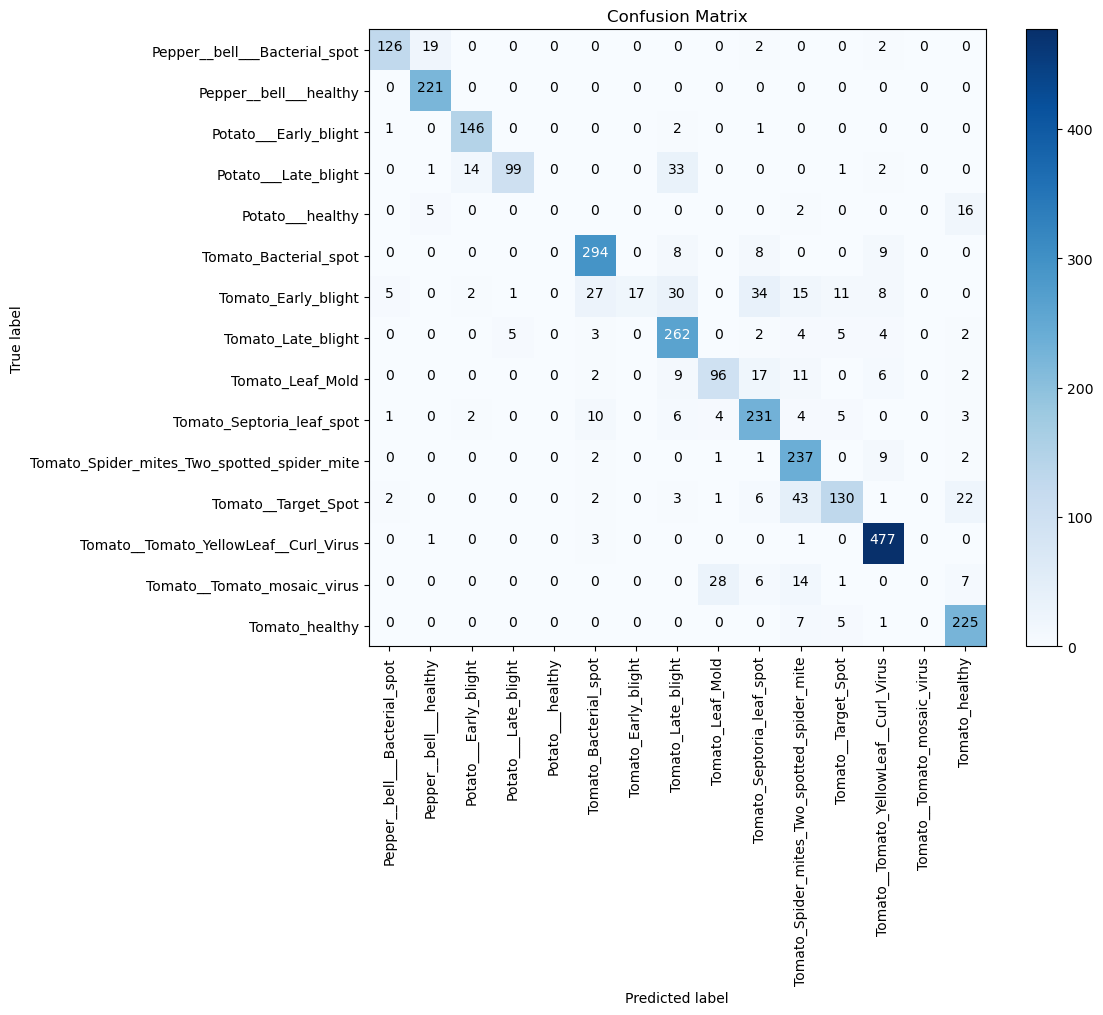

In [94]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Calculate Top-5 accuracy
y_pred_tensor = torch.Tensor(outputs.predictions)
y_true_tensor = torch.Tensor(outputs.label_ids)
top_5_accuracy = (y_pred_tensor.topk(5, dim=1).indices == y_true_tensor.unsqueeze(1)).any(dim=1).float().mean().item()

# Calculate Precision, Recall, and F1 Score (macro average)
precision, recall, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)

# Calculate Precision, Recall, and F1 Score (weighted average)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

# Print the calculated metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")
print(f"Top-5 Accuracy: {top_5_accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted): {recall_weighted:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 250:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(12, 10))
    
# Finally, display classification report
# print()
# print("Classification report:")
# print()
# print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

## Train data logs

In [95]:

# # Plot learning rate
# plt.figure()
# plt.plot(range(len(lr_callback.lrs)), lr_callback.lrs)
# plt.xlabel("Steps")
# plt.ylabel("Learning Rate")
# plt.title("Learning Rate Schedule")
# plt.show()

# # Plot accuracy
# plt.figure()
# epochs = range(1, len(accuracy_callback.val_accuracies) + 1)
# plt.plot(epochs, accuracy_callback.train_accuracies, label="Training Accuracy")
# plt.plot(epochs, accuracy_callback.val_accuracies, label="Validation Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.title("Training and Validation Accuracy")
# plt.show()

# # Plot GPU usage
# plt.figure()
# plt.plot(range(len(gpu_callback.gpu_usage)), gpu_callback.gpu_usage)
# plt.xlabel("Steps")
# plt.ylabel("GPU Memory Usage (MB)")
# plt.title("GPU Usage During Training")
# plt.show()